Reference from
 - code : https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb#scrollTo=jloGNS1MLx3A
 - data : https://www.kaggle.com/datasets/vencerlanz09/sea-animals-image-dataste?select=Turtle_Tortoise

### **Import Library**

In [ ]:
#import libary
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist         # Grapth
from tensorflow.keras.models import Sequential      # model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout   # use command in model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator   # resharp image
import pandas as pd
import matplotlib.pyplot as plt                    # run show grapth
import math
import numpy as np
import cv2                                      #pip3 install opencv-python
import urllib                                   # link into colab
import PIL                                     #  config detail image
import seaborn as sns                          # type grapth
from glob import glob                         # read file surname

In [ ]:
from google.colab import drive  #google colab connect to goole drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **DOWNLOAD FILE FROM (GOOGLE-DRIVE TO GOOGLE COLAB)**

In [ ]:
!gdown --id 1eSJOT1kfftuwOHFFgrWBBo4AF6c0Jj4J

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1eSJOT1kfftuwOHFFgrWBBo4AF6c0Jj4J
To: /content/kaggle.json
100% 75.0/75.0 [00:00<00:00, 177kB/s]


In [ ]:
!cp '/content/drive/MyDrive/Kaggle/kaggle.json' '/content' #download file .json to drive

cp: cannot stat '/content/drive/MyDrive/Kaggle/kaggle.json': No such file or directory


In [ ]:
import zipfile
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content"

### **DOWNLOAD URL DATASET FROM KIGGLE**

In [ ]:
!kaggle datasets download -d thapakornmeethangzr/test-data #api kaggle

 98% 219M/223M [00:08<00:00, 26.3MB/s]
100% 223M/223M [00:08<00:00, 28.7MB/s]


In [ ]:
zip_ref = zipfile.ZipFile('test-data.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content') #Extracts the files into the /tmp folder
zip_ref.close()

### **SELECT FILE PATH**

In [ ]:
import pathlib

data_set = "/content/TestData"   #load image to data_set
image_count = len(os.listdir(data_set))

image_access = os.listdir(data_set)
dataAll_set = pathlib.Path(data_set)   #all image in dataAll_set(path)

image_count = len(list(dataAll_set.glob("*/*.jpg"))) #check
print(image_count)        #print amount of data

9801


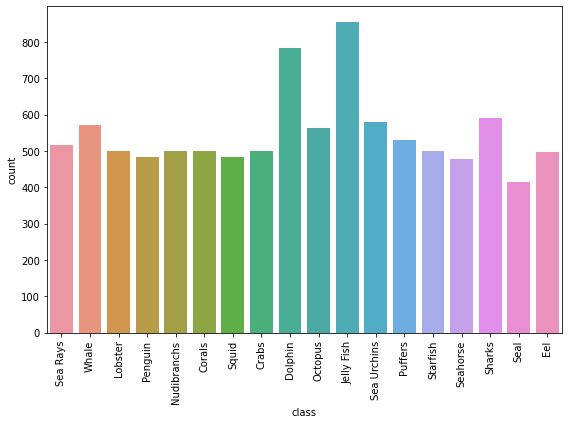

In [ ]:
DF = pd.DataFrame(columns=['class','count'])
DF['class']=pd.Series([os.listdir(data_set)[x] for x in range(0,18)])
DF['count']=pd.Series([len(os.listdir(os.path.join(data_set,os.listdir(data_set)[x]))) for x in range(0,18)])
plt.figure(figsize=(8,6))
g=sns.barplot(x='class', y='count',data=DF)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.tight_layout()
#show Displays the amount of data in each class

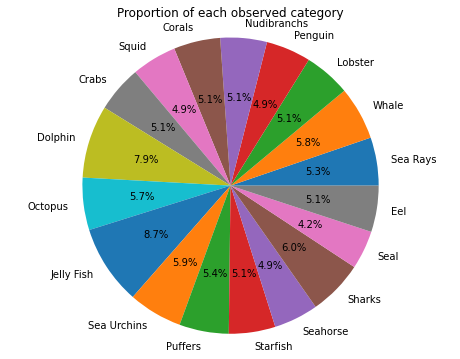

In [ ]:
plt.figure(figsize=(8,6))
plt.tight_layout()
plt.pie(DF['count'],
        labels=DF['class'],
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()
#show Displays the amount of data in each class but circle

### TEST FILE **DATA**

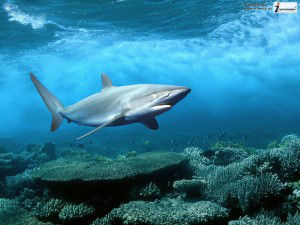

In [ ]:
ocean = list(dataAll_set.glob("Sharks/*"))
PIL.Image.open(str(ocean[55]))
#PIL.Image.open(str(ocean[125]))
#Example image in the data

### **CONFIGURATION**

In [ ]:
# Define some parameter
batch_size = 16  # input data size
img_height = 64   # image height 128 pixel
img_width = 64   # image width 128 pixel

In [ ]:
 train_ds = tf.keras.utils.image_dataset_from_directory(
  dataAll_set,
  validation_split=0.55,                                                 #Separate validation set 45% dodge
  subset="training",                                                     #let this dataset be training
  seed=123,                                                              #This is so that the result of a randomly split data set doesn't change much each time the code is run.
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9839 files belonging to 18 classes.
Using 4428 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataAll_set,
  validation_split=0.45,                                               #Separate validation set 55% dodge
  subset="validation",                                                 #let this dataset be validation
  seed=123,                                                            #This is so that the result of a randomly split data set doesn't change much each time the code is run.
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9839 files belonging to 18 classes.
Using 4427 files for validation.


In [ ]:
class_name = train_ds.class_names
print(class_name)    #print all class name

['Corals', 'Crabs', 'Dolphin', 'Eel', 'Jelly Fish', 'Lobster', 'Nudibranchs', 'Octopus', 'Penguin', 'Puffers', 'Sea Rays', 'Sea Urchins', 'Seahorse', 'Seal', 'Sharks', 'Squid', 'Starfish', 'Whale']


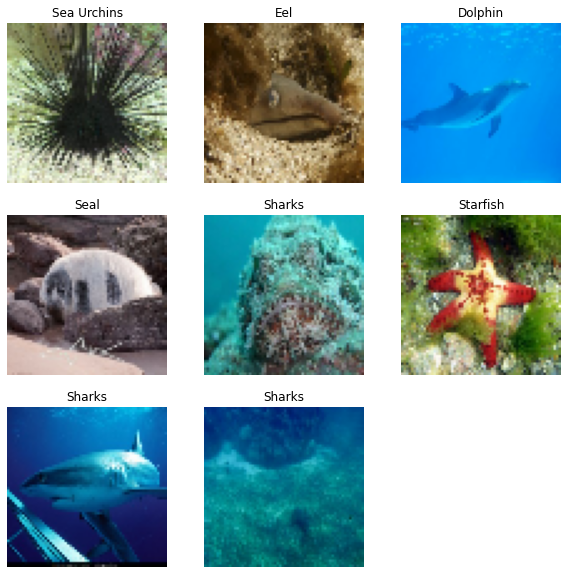

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_name[labels[i]])
    plt.axis("off")
    #Example image in the class quantity 8 image

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 64, 64, 3)
(16,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE    #Parameters in batch number, which TensorFlow will handle appropriate amounts.

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)   #while the model is training We can read the data in the next batch without having to wait for the model to finish training first.
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)               #same as above line

In [ ]:
normalization_layer = layers.Rescaling(1./255)  # rescale max 255 to 1 and 0 to 0

### **CONFIGURATION MODEL**

In [ ]:
# Keras Model
num_class = len(class_name)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #layer(hidden)  .Conv2D('flatter', 'channal' , padding='same = ', activation='relu')
  #same = Forces this class to export data of the same size.
  #relu = is to "pass off" the linear function by choosing to turn off some neurons completely if the neuron is low.
  # .MaxPooling = Reduce the size of the tiles in the hidden layer.
  #Dropout = drop data 1 = 100%
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),

  #.Flatten = It is intended to convert data from multiple channel images into vectors. that we can pass on to the standard MLP layer
  layers.Flatten(),

    # .Dense is fully connected or connect each and every node of one layer to another layer
  layers.Dense(128, activation='relu'),
  layers.Dense(num_class),

])


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],)


### SHOW DETAIL PARAMETER, LAYER

In [ ]:
model.summary()  #show overall

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                    

### Process Train Model

In [ ]:
history = model.fit(
  train_ds,                      #train data
  validation_data=val_ds, #test data
  epochs=15,                 #Number of cycles for train and test
  verbose=1,                  #display format the training progress for each epoch
  validation_split=0.2      #drop 20 percent off
)

Epoch 1/15
277/277 [==============================] - 17s 18ms/step - loss: 2.5024 - accuracy: 0.1920 - val_loss: 2.3388 - val_accuracy: 0.2406
Epoch 2/15
277/277 [==============================] - 3s 10ms/step - loss: 2.2121 - accuracy: 0.2963 - val_loss: 2.2805 - val_accuracy: 0.2785
Epoch 3/15
277/277 [==============================] - 3s 9ms/step - loss: 2.0790 - accuracy: 0.3331 - val_loss: 2.1015 - val_accuracy: 0.3296
Epoch 4/15
277/277 [==============================] - 3s 10ms/step - loss: 1.9598 - accuracy: 0.3679 - val_loss: 2.0888 - val_accuracy: 0.3343
Epoch 5/15
277/277 [==============================] - 3s 12ms/step - loss: 1.8577 - accuracy: 0.4061 - val_loss: 2.0479 - val_accuracy: 0.3386
Epoch 6/15
277/277 [==============================] - 3s 10ms/step - loss: 1.7254 - accuracy: 0.4433 - val_loss: 2.0316 - val_accuracy: 0.3551
Epoch 7/15
277/277 [==============================] - 3s 10ms/step - loss: 1.5756 - accuracy: 0.4874 - val_loss: 2.0643 - val_accuracy: 0.3574

### SHOW RESULT (GRAPTH)

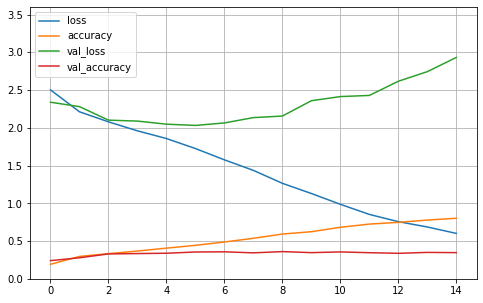

In [ ]:
err_hist = history.history
pd.DataFrame(err_hist).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3.6) # set the vertical range to [0-1]
plt.show()

In [ ]:
score = model.evaluate(train_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', 100*score[1])

Test loss: 0.340273380279541
Test accuracy: 91.3504958152771


28318/28318 [==============================] - 0s 0us/step


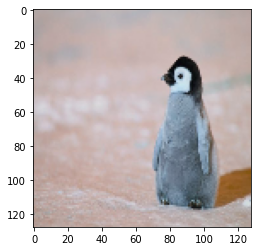

1/1 [==============================] - 0s 162ms/step
This image most likely belongs to Dolphin with a 58.61 percent confidence.


In [ ]:
#test_image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/Abbott%27s_Booby.jpg/800px-Abbott%27s_Booby.jpg"
#test_image_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQmRdQ56h4E8Ub6qJej1mgrFxS2YtVl8f2lHYkncNk0C-wgjQcQPyUGSYoVC7o0PYJ_VIk&usqp=CAU"
test_image_url = "https://www.cabq.gov/artsculture/biopark/news/10-cool-facts-about-penguins/@@images/1a36b305-412d-405e-a38b-0947ce6709ba.jpeg"
#test_image_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTswrTmk8h-q27Fn9gxZbqh3nwsDu_-fQGiWw&usqp=CAU"
test_image_path = tf.keras.utils.get_file(origin=test_image_url)

req = urllib.request.urlopen(test_image_url)
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1)
img2 = cv2.resize(img,[128,128])

plt.imshow(img2)
plt.show()

img = tf.keras.utils.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_name[np.argmax(score)], 100 * np.max(score))
)
